In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from UTILS import preprocessing_experiment2, general_cleaning, simple_cleaning_experiment2,verification_based_on_initial_record,\
OneTimeSeriesPlot, ZoneVariable, HenVariable, print_color, boxplot_distribution_entropy, heatmap_duration_perzone_perhen, \
time_series_henColumn_tsRow, cleaning_mouvement_records, HenEntropy, TimeSeriesPlot_1row1day, is_day
import config_experiment2 as config

# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
nbr_sec_bining = config.nbr_sec_bining
dico_matching = config.dico_matching
dico_zone_order = config.dico_zone_order
ts_name = 'time_serie_day'
print(id_run)
print('The date that will be removed are: \n %s'%' \n '.join([str(d) for d in sorted(config.li_date2remove)]))

change the configuration file if not done yet!
ENTROPYSELECTION_
The date that will be removed are: 
 2019-11-28 00:00:00 
 2019-11-29 00:00:00 
 2019-12-02 00:00:00 
 2019-12-04 00:00:00 
 2019-12-06 00:00:00 
 2019-12-09 00:00:00 
 2019-12-11 00:00:00 
 2019-12-21 00:00:00 
 2019-12-22 00:00:00 
 2019-12-23 00:00:00 
 2019-12-26 00:00:00 
 2019-12-27 00:00:00 
 2019-12-28 00:00:00 
 2019-12-29 00:00:00 
 2019-12-30 00:00:00 
 2019-12-31 00:00:00 
 2020-01-01 00:00:00 
 2020-01-02 00:00:00 
 2020-01-03 00:00:00 
 2020-01-04 00:00:00 
 2020-01-05 00:00:00 
 2020-01-06 00:00:00 
 2020-01-07 00:00:00 
 2020-01-12 00:00:00 
 2020-01-21 00:00:00 
 2020-01-22 00:00:00 
 2020-01-23 00:00:00 
 2020-01-24 00:00:00 
 2020-01-25 00:00:00 
 2020-01-26 00:00:00 
 2020-01-27 00:00:00 
 2020-01-28 00:00:00 
 2020-01-29 00:00:00 
 2020-01-30 00:00:00 
 2020-01-31 00:00:00 
 2020-02-01 00:00:00 
 2020-02-02 00:00:00 
 2020-02-10 00:00:00 
 2020-02-13 00:00:00 
 2020-03-16 00:00:00 
 2020-03-17 00:00:0

# Variables at Hen level

In [4]:
#for being more reproductible, we open the file that was saved from cleaning
df_ts = pd.read_csv(os.path.join(path_extracted_data, id_run+'ts_MostFrequentZone_period60_allhens.csv'), sep=';', 
                    parse_dates=['New_Timestamp']) 
print(df_ts.shape)
print(min(df_ts['New_Timestamp']), max(df_ts['New_Timestamp']))
df_ts.head(3)

(27001, 109)
2020-02-26 06:00:00 2020-03-16 00:00:00


,New_Timestamp,hen_10bb,hen_10bs,hen_10gb,hen_10gg,hen_10gp,hen_10gs,hen_10pb,hen_10pp,hen_10ps,...,hen_5ps,hen_5sb,hen_5sg,hen_5sp,hen_5ss,hen_5sws,hen_5wb,hen_5wg,hen_5wp,hen_5ws
0,2020-02-26 06:00:00,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone
1,2020-02-26 06:01:00,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone
2,2020-02-26 06:02:00,2 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone


In [17]:
timestamp_name = 'New_Timestamp'
path_extracted_data = config.path_extracted_data
id_run = config.id_run
dico_night_hour = config.dico_night_hour
dico_zone_order = config.dico_zone_order
nbr_sec_bining = config.nbr_sec_bining

############ add correct 'level' variable (i.e. consecutive time slot for night time series)
df_ts['day'] = df_ts[timestamp_name].map(lambda x: dt.datetime(x.year,x.month,x.day)) 
df_ts['is_day'] = df_ts[timestamp_name].map(lambda x: is_day(x, dico_night_hour))
#note that minuit is: 0, and its date should be as 1,2 (day-1, day)
if ts_name == 'time_serie_night':
    df_ts = df_ts[~df_ts['is_day']].copy()
    df_ts['level'] = df_ts[timestamp_name].map(lambda x: str(x)[0:-9]+'_'+str(x+dt.timedelta(days=1))[8:10] if\
                                            name_level(x,dico_night_hour) else str(x-dt.timedelta(days=1))[0:-9]+'_'+str(x)[8:10])
elif ts_name == 'time_serie_day':
    df_ts = df_ts[df_ts['is_day']].copy()
    df_ts['level'] = df_ts['day'].copy()
else:
    print('ERROR: ts_name parameter must either be time_serie_night or time_serie_day')
    sys.exit()

############ verifications
#compute nbr_sec computation here (list of difference between each timestamp, and must always be the same)
li_ts = df_ts[timestamp_name].tolist()
li_diff_ts = list(set(list(map(operator.sub, li_ts[1:], li_ts[0:-1]))))
if len(li_diff_ts)!=1:
    print('WARNING: your timestamp columns have different one to one difference: ', li_diff_ts)
    #return(df_ts)
    #sys.exit()
#verify columns name of df_ts and select the column we need
li_hen = [i for i in list(df_ts) if i.startswith('hen_')]
if not all([i in df_ts.columns for i in [timestamp_name,'level']]):
    print('ERROR: your df_ts must have timestamp and level column name')
    sys.exit()
df = df_ts.filter([timestamp_name,'level']+li_hen).copy()

In [18]:
df_ts.head(3)

,New_Timestamp,hen_10bb,hen_10bs,hen_10gb,hen_10gg,hen_10gp,hen_10gs,hen_10pb,hen_10pp,hen_10ps,...,hen_5sp,hen_5ss,hen_5sws,hen_5wb,hen_5wg,hen_5wp,hen_5ws,day,is_day,level
0,2020-02-26 06:00:00,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26,True,2020-02-26
1,2020-02-26 06:01:00,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26,True,2020-02-26
2,2020-02-26 06:02:00,2 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26,True,2020-02-26


In [19]:
df.head(3)

,New_Timestamp,level,hen_10bb,hen_10bs,hen_10gb,hen_10gg,hen_10gp,hen_10gs,hen_10pb,hen_10pp,...,hen_5ps,hen_5sb,hen_5sg,hen_5sp,hen_5ss,hen_5sws,hen_5wb,hen_5wg,hen_5wp,hen_5ws
0,2020-02-26 06:00:00,2020-02-26,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,...,2 Zone,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone
1,2020-02-26 06:01:00,2020-02-26,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,...,2 Zone,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone
2,2020-02-26 06:02:00,2020-02-26,2 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,...,2 Zone,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone


In [20]:
############ one row per unique hen-timestamp 
df = pd.melt(df, id_vars=[timestamp_name,'level'], value_vars=li_hen)
df.rename(columns={'variable':'HenID','value':'Zone'}, inplace=True)
df['duration_sec'] = nbr_sec_bining
#list of not nan Zones
li_Zone = [x for x in df[~df['Zone'].isnull()]['Zone'].unique()]
df.head(3)

,New_Timestamp,level,HenID,Zone,duration_sec
0,2020-02-26 06:00:00,2020-02-26,hen_10bb,3 Zone,60
1,2020-02-26 06:01:00,2020-02-26,hen_10bb,3 Zone,60
2,2020-02-26 06:02:00,2020-02-26,hen_10bb,2 Zone,60


In [22]:
df[df['HenID']=='hen_10gb']

,New_Timestamp,level,HenID,Zone,duration_sec
33720,2020-02-26 06:00:00,2020-02-26,hen_10gb,2 Zone,60
33721,2020-02-26 06:01:00,2020-02-26,hen_10gb,2 Zone,60
33722,2020-02-26 06:02:00,2020-02-26,hen_10gb,2 Zone,60
33723,2020-02-26 06:03:00,2020-02-26,hen_10gb,2 Zone,60
33724,2020-02-26 06:04:00,2020-02-26,hen_10gb,2 Zone,60
33725,2020-02-26 06:05:00,2020-02-26,hen_10gb,3 Zone,60
33726,2020-02-26 06:06:00,2020-02-26,hen_10gb,3 Zone,60
33727,2020-02-26 06:07:00,2020-02-26,hen_10gb,3 Zone,60
33728,2020-02-26 06:08:00,2020-02-26,hen_10gb,3 Zone,60
33729,2020-02-26 06:09:00,2020-02-26,hen_10gb,3 Zone,60


In [5]:
#open time series per session and compute the variables for each session (car time series make sence at session level), et en 
#plus des variables tel que running entropy over the whole session ateach last timestamp of each level make sence only at 
#session level
df = HenEntropy(df_ts, config, ts_name, name_='', timestamp_name='New_Timestamp')
print(df.shape)
df.head(3)

----------------- total duration per Zone in seconds....
The number of hours per "level" period is of:


Zone,verification_daily_total_nbr_hour,level,HenID
0,11.0,"[2020-02-26 00:00:00, 2020-02-26 00:00:00, 202...","[hen_10bb, hen_10bs, hen_10gb, hen_10gg, hen_1..."
1,15.0,"[2020-02-27 00:00:00, 2020-02-28 00:00:00, 202...","[hen_10bb, hen_10bb, hen_10bb, hen_10bb, hen_1..."


,New_Timestamp,level,HenID,Zone,duration_sec
0,2020-02-26 06:00:00,2020-02-26,hen_10bb,3 Zone,60
1,2020-02-26 06:01:00,2020-02-26,hen_10bb,3 Zone,60
2,2020-02-26 06:02:00,2020-02-26,hen_10bb,2 Zone,60


(1820880, 5)


,New_Timestamp,level,HenID,Zone,duration_sec
0,2020-02-26 06:00:00,2020-02-26,hen_10bb,3 Zone,60
1,2020-02-26 06:01:00,2020-02-26,hen_10bb,3 Zone,60
2,2020-02-26 06:02:00,2020-02-26,hen_10bb,2 Zone,60


In [9]:
dico_HenID_day_ent = {}
for k, df_hen in df.groupby(['HenID']):
    df_hen = df_hen[~df_hen['Zone'].isnull()]
    df_hen['Zone'] = df_hen['Zone'].map(lambda x: dico_zone_order[x])
    dico_HenID_day_ent[k] = {}
    for L in df_hen['level'].unique():
        df_ = df_hen[df_hen['level']<=L]
        ts_value = df_.tail(1)[timestamp_name].values[0]
        li_zone = df_['Zone'].tolist()
        nbr_value = len(li_zone)
        dico_HenID_day_ent[k][pd.to_datetime(L)] = {'SampEnt': sample_entropy(li_zone, order=2, metric='chebyshev'),
                                                    'DistEnt': DistributionEntropy(li_zone), 
                                                    'ts_value': ts_value, 'nbr_value': nbr_value}

NameError: name 'timestamp_name' is not defined

In [12]:
df_hen = df_hen.sort_values('level',ascending=True)
df_hen

,New_Timestamp,level,HenID,Zone,duration_sec
0,2020-02-26 06:00:00,2020-02-26,hen_10bb,2,60
436,2020-02-26 13:16:00,2020-02-26,hen_10bb,2,60
437,2020-02-26 13:17:00,2020-02-26,hen_10bb,2,60
438,2020-02-26 13:18:00,2020-02-26,hen_10bb,2,60
439,2020-02-26 13:19:00,2020-02-26,hen_10bb,2,60
440,2020-02-26 13:20:00,2020-02-26,hen_10bb,1,60
441,2020-02-26 13:21:00,2020-02-26,hen_10bb,1,60
442,2020-02-26 13:22:00,2020-02-26,hen_10bb,1,60
435,2020-02-26 13:15:00,2020-02-26,hen_10bb,2,60
443,2020-02-26 13:23:00,2020-02-26,hen_10bb,1,60


In [ ]:
df_daily['RunSampEnt_onLastTsOfEachLevel'] = df_daily.apply(lambda x: dico_HenID_day_ent[x['HenID']][x['level']]['SampEnt'],
                                                            axis=1)
df_daily['RunDistEnt_onLastTsOfEachLevel'] = df_daily.apply(lambda x: dico_HenID_day_ent[x['HenID']][x['level']]['DistEnt'],
                                                        axis=1)
df_daily['RunEnt_onLastTsOfEachLevel_nbr_value'] = df_daily.apply(lambda x: dico_HenID_day_ent[x['HenID']][x['level']]
                                                                      ['nbr_value'], axis=1)
df_daily['RunEnt_onLastTsOfEachLevel_ts_value'] = df_daily.apply(lambda x: dico_HenID_day_ent[x['HenID']][x['level']]
                                                                     ['ts_value'], axis=1)    

# Separate high entropy and low entropy birds

In [4]:
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_'+ts_name+'__variables.csv'), sep=';')
display(df_daily.head(3))
df_daily.shape

,HenID,level,duration_1 Zone,duration_2 Zone,duration_3 Zone,duration_4 Zone,duration_5 Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,RunSampEnt_onLastTsOfEachLevel,RunDistEnt_onLastTsOfEachLevel,RunEnt_onLastTsOfEachLevel_nbr_value,RunEnt_onLastTsOfEachLevel_ts_value
0,hen_10bb,2020-02-26,0.0,30540.0,8640.0,0.0,420.0,39600.0,11.0,0.165675,0.580739,660,2020-02-26 16:59:00
1,hen_10bb,2020-02-27,240.0,38040.0,12480.0,1440.0,1800.0,54000.0,15.0,0.166989,0.732086,1560,2020-02-27 16:59:00
2,hen_10bb,2020-02-28,840.0,36600.0,13320.0,1320.0,1920.0,54000.0,15.0,0.173083,0.791652,2460,2020-02-28 16:59:00


(2052, 13)

In [5]:
df_ts = pd.read_csv(os.path.join(path_extracted_data, id_run+'ts_MostFrequentZone_period60_allhens.csv'), sep=';', 
                    parse_dates=['New_Timestamp']) 
df_ts['day'] = df_ts['New_Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
display(df_ts.head(3))

,New_Timestamp,hen_10bb,hen_10bs,hen_10gb,hen_10gg,hen_10gp,hen_10gs,hen_10pb,hen_10pp,hen_10ps,...,hen_5sb,hen_5sg,hen_5sp,hen_5ss,hen_5sws,hen_5wb,hen_5wg,hen_5wp,hen_5ws,day
0,2020-02-26 06:00:00,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26
1,2020-02-26 06:01:00,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26
2,2020-02-26 06:02:00,2 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26


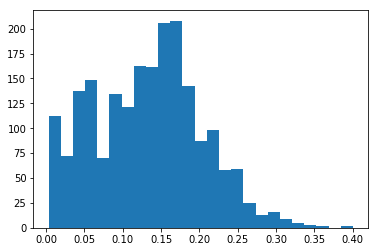

In [6]:
plt.hist(df_daily['RunSampEnt_onLastTsOfEachLevel'].dropna(),bins='auto');

In [12]:
for h in df_daily['HenID'].unique():
    for d in df_daily[df_daily['HenID']==h]['level'].unique():
        v = df_daily[(df_daily['HenID']==h) & (df_daily['level']==d)]['RunSampEnt_onLastTsOfEachLevel'].values[0]
        if v>0.25:
            entropy_type = 'ts_highEntropy'
        elif v<0.05:
            entropy_type = 'ts_lowEntropy'
        else:
            entropy_type = 'ts_middleEntropy'
        path_ = os.path.join(path_extracted_data,'visual','TimeSeriesPlot', entropy_type)
        #create a director if not existing
        if not os.path.exists(path_):
            os.makedirs(path_)
        #sort the yaxis
        #s = sorted(dico_zone_order.items(), key=operator.itemgetter(1))
        #li_zone_in_order = [x[0] for x in s]
        df_plt = df_ts[(~df_ts[h].isnull()) & (df_ts['day']==d)].sort_values(['New_Timestamp']).copy()
        df_plt[h] = df_plt[h].map(lambda x: int(dico_zone_order[x]))
        plt.plot(df_plt[h].tolist());
        plt.title(str(d)+'_'+h+'_'+str(v))
        plt.savefig(os.path.join(path_, id_run+'_'+str(d)+'_'+h+'.png'), dpi=300, format='png', bbox_inches='tight')      
        #plt.show();
        plt.close()